In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import datetime
import scipy.stats

import thinkstats2

from matplotlib import pyplot as plt

In [2]:
transactions = pd.read_csv('mj-clean.csv', parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [3]:
qual_grp = transactions[['date','ppg']].groupby('date').mean().reset_index()
qual_grp.head()

,date,ppg
0,2010-09-02,11.727733
1,2010-09-03,11.972892
2,2010-09-04,13.752500
3,2010-09-05,15.113333
4,2010-09-06,15.537500


[(733996.0, 735426.0), Text(0.5,1,'Mean daily price of weed')]

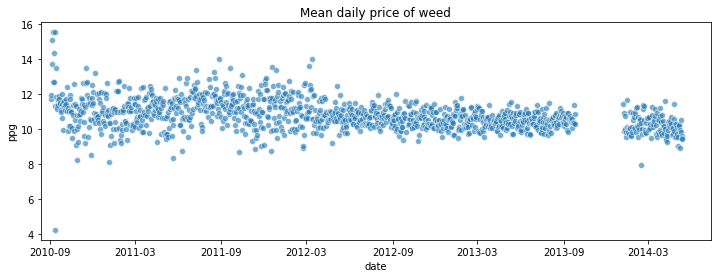

In [4]:
plt.figure(figsize=(12,4))
a = sns.scatterplot(x=qual_grp['date'], y=qual_grp['ppg'], alpha=0.6)

a.set(xlim=('2010-8-12', '2014-7-12'), title='Mean daily price of weed')

In [5]:
low = transactions[transactions['quality'] == 'low']
med = transactions[transactions['quality'] == 'medium']
high = transactions[transactions['quality'] == 'high']

grp_low = low[['date','ppg']].groupby('date').mean().reset_index()
grp_med = med[['date','ppg']].groupby('date').mean().reset_index()
grp_high = high[['date','ppg']].groupby('date').mean().reset_index()

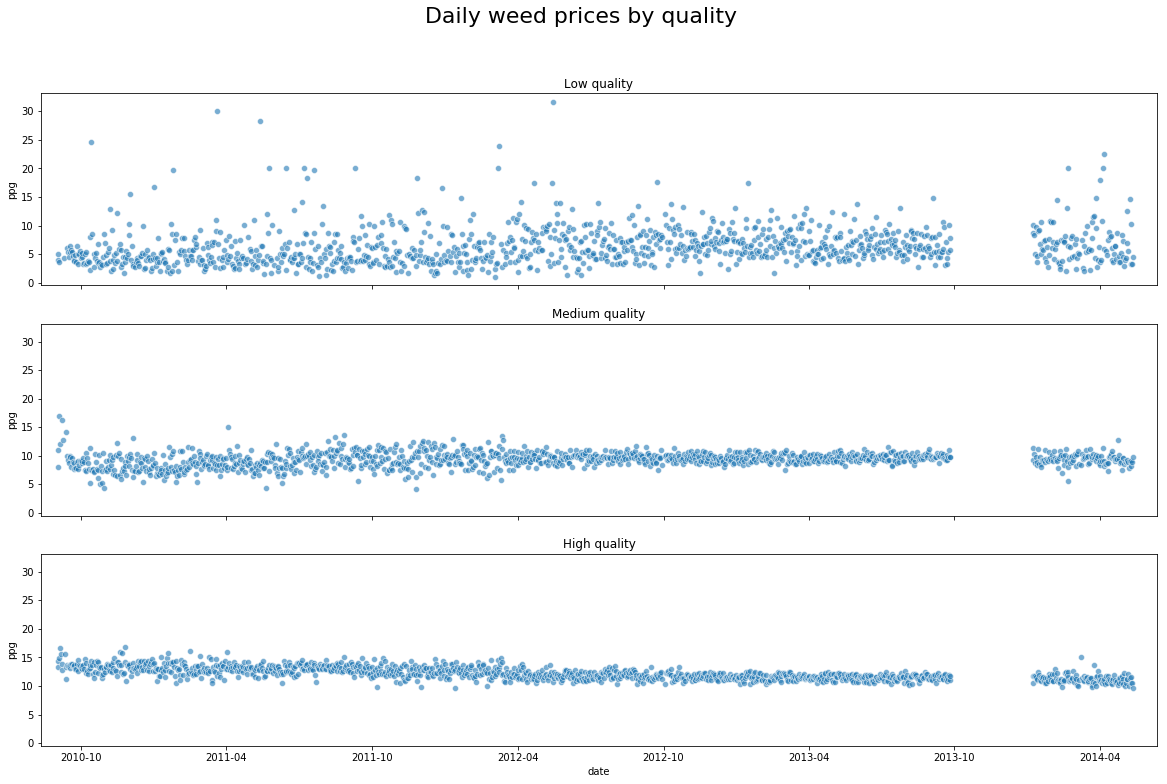

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,12), sharex=True, sharey=True)

a1 = sns.scatterplot(x=grp_low['date'], y=grp_low['ppg'], ax=ax1, alpha=0.6)
a2 = sns.scatterplot(x=grp_med['date'], y=grp_med['ppg'], ax=ax2, alpha=0.6)
a3 = sns.scatterplot(x=grp_high['date'], y=grp_high['ppg'], ax=ax3, alpha=0.6)

a1.set(xlim=('2010-8-12', '2014-6-12'), title='Low quality')
a2.set(xlim=('2010-8-12', '2014-6-12'), title='Medium quality')
a3.set(xlim=('2010-8-12', '2014-6-12'), title='High quality')

fig.suptitle('Daily weed prices by quality', size=22)
fig.subplots_adjust(top=0.88)

In [7]:
# Converting the 'date' column to 'years' for the least squares fit to work.

data = [grp_low, grp_med, grp_high]
one_year = np.timedelta64(1, 'Y')
start = grp_low.date[0]

for grp in data:
    grp['years'] = (grp.date - start) / one_year

grp_low.head()

,date,ppg,years
0,2010-09-02,4.943750,0.000000
1,2010-09-03,3.984138,0.002738
2,2010-09-04,3.530000,0.005476
3,2010-09-10,4.240000,0.021903
4,2010-09-14,6.066118,0.032855


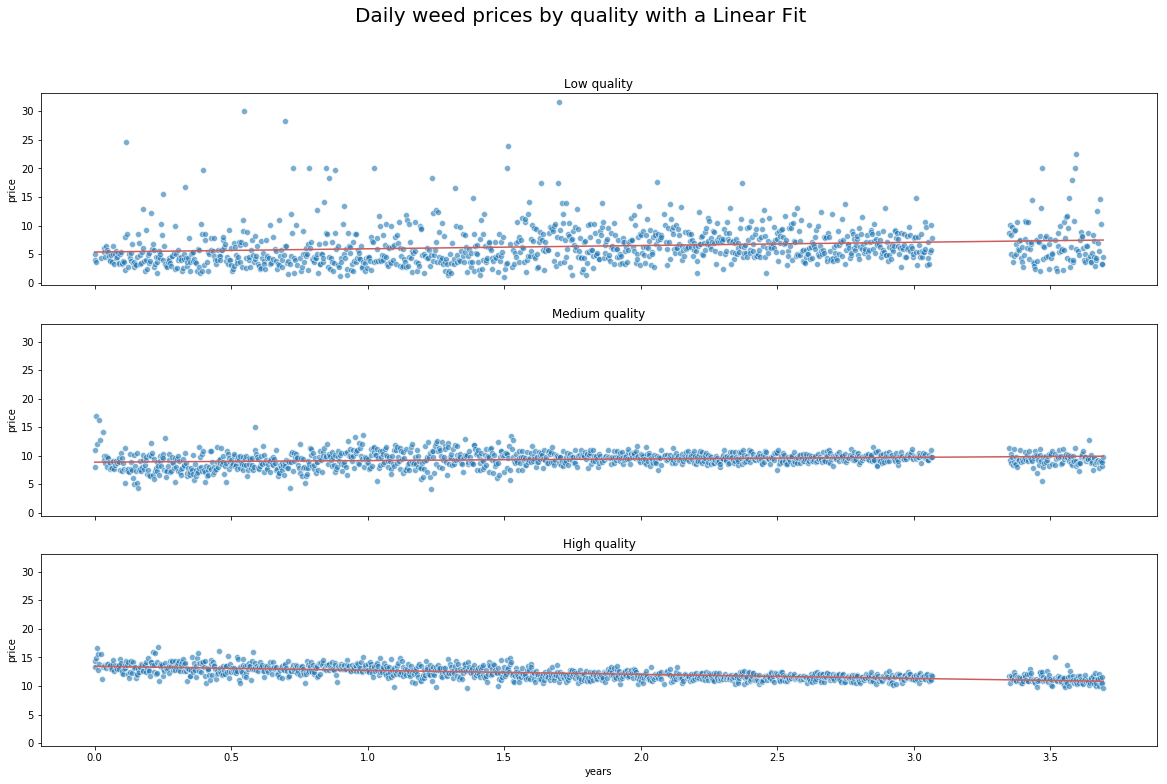

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,12), sharex=True, sharey=True)

b1,m1 = polyfit(x=grp_low['years'], y=grp_low['ppg'], deg=1)
b2,m2 = polyfit(x=grp_med['years'], y=grp_med['ppg'], deg=1)
b3,m3 = polyfit(x=grp_high['years'], y=grp_high['ppg'], deg=1)
    
a1 = sns.scatterplot(x=grp_low['years'], y=grp_low['ppg'], ax=ax1, alpha=0.6).set_title('Low quality')
sns.lineplot(x=grp_low['years'], y=b1 + m1 * grp_low['years'], ax=ax1, color='#CD5C5C')
ax1.set(ylabel='price')

a2 = sns.scatterplot(x=grp_med['years'], y=grp_med['ppg'], ax=ax2, alpha=0.6).set_title('Medium quality')
sns.lineplot(x=grp_med['years'], y=b2 + m2 * grp_med['years'], ax=ax2, color='#CD5C5C')
ax2.set(ylabel='price')

a3 = sns.scatterplot(x=grp_high['years'], y=grp_high['ppg'], ax=ax3, alpha=0.6).set_title('High quality')
sns.lineplot(x=grp_high['years'], y=b3 + m3 * grp_high['years'], ax=ax3, color='#CD5C5C')
ax3.set(ylabel='price')

fig.suptitle('Daily weed prices by quality with a Linear Fit', size=20)
fig.subplots_adjust(top=0.88)

In [9]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x=grp_low['years'], y=grp_low['ppg'])

print(slope, intercept)
print(b1, m1)

0.5683446627178519 5.361599499153263
5.361599499153259 0.5683446627178519


In [10]:
grp_high.set_index('date', inplace=True)

In [11]:
# A moving average is more useful for analyzing this type of data, but first we're going to have to deal with missing dates.
# We do that by reindexing the dataframe.

dates = pd.date_range(grp_high.index.min(), grp_high.index.max())
reindexed = grp_high.reindex(dates)
reindexed['roll_mean'] = reindexed['ppg'].rolling(30).mean()

Text(0.5,1,'High quality weed EWMA plot')

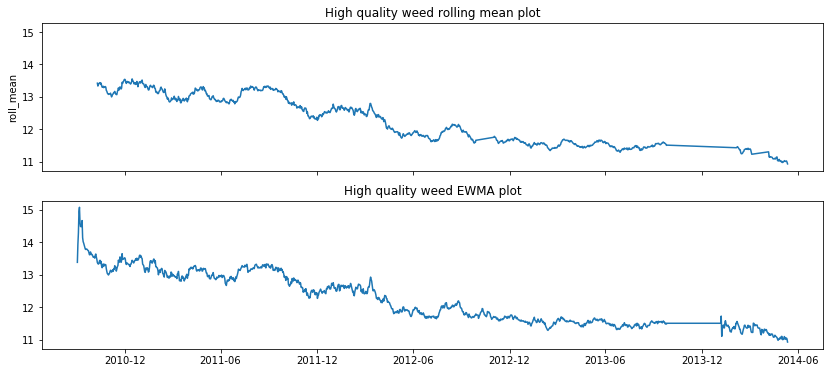

In [12]:
# Exponentially-weighted moving average(EWMA) plot

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14,6), sharex=True, sharey=True)

ewma = reindexed['ppg'].ewm(span=30).mean()
ewma = dict(ewma)

sns.lineplot(x=reindexed.index, y=reindexed['roll_mean'], ax=ax1).set_title('High quality weed rolling mean plot')
sns.lineplot(x=list(ewma.keys()), y=list(ewma.values()), ax=ax2).set_title('High quality weed EWMA plot')

#sns.scatterplot(x=reindexed.index, y=reindexed['ppg'], ax=ax1, alpha=0.6)

In [13]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    
    def TestStatistic(self, data):
        series, lag = data
        xs = series[lag:]
        ys = np.roll(series, lag)[lag:]
        corr = np.corrcoef(xs,ys)[0][1]
        return corr
    
    def RunModel(self):
        series, lag = self.data
        series = np.random.permutation(series)
        return series, lag

In [14]:
htest = SerialCorrelationTest((transactions['price'], 4))
htest.PValue()

0.082

In [15]:
#calculating intercept

ewma = grp_high['ppg'].ewm(span=365).mean()
ewma = dict(ewma)
inter = list(ewma.values())[-1]

In [16]:
#calculating slope

diffs = np.diff(grp_high['ppg'])
ewma_diffs = pd.Series(diffs).ewm(span=365).mean()
slope = ewma_diffs.values[-1]
print(inter,slope)

11.3966242484501 -0.009869418033379162


In [17]:
# filling missing date values

temp_dates = pd.date_range(grp_high.index.min(), grp_high.index.max())
filled = grp_high.reindex(temp_dates)

filled['ewma'] = filled['ppg'].ewm(span=30).mean().values
resid = (filled['ppg'] - filled['ewma']).dropna()
fake_data = filled['ewma'] + np.random.choice(resid, len(filled['ewma']), replace=True)
filled['ppg'].fillna(fake_data, inplace=True)

filled.head()

,ppg,years,ewma
2010-09-02,13.384186,0.000000,13.384186
2010-09-03,14.459588,0.002738,13.939810
2010-09-04,14.923333,0.005476,14.289742
2010-09-05,16.667500,0.008214,14.944901
2010-09-06,15.537500,0.010952,15.079732


In [18]:
dates = pd.date_range(grp_high.index.min(), 
                      grp_high.index.max() + np.timedelta64(365, 'D'))

predicted = filled.reindex(dates)
predicted.tail()

,ppg,years,ewma
2015-05-09,NaN,NaN,NaN
2015-05-10,NaN,NaN,NaN
2015-05-11,NaN,NaN,NaN
2015-05-12,NaN,NaN,NaN
2015-05-13,NaN,NaN,NaN


In [19]:
start = filled.index.max()
predicted['days'] = (predicted.index - start).days
predict = inter + slope*predicted['days']
predicted['ewma'].fillna(predict, inplace=True)
predicted.tail()

,ppg,years,ewma,days
2015-05-09,NaN,NaN,7.833764,361
2015-05-10,NaN,NaN,7.823895,362
2015-05-11,NaN,NaN,7.814026,363
2015-05-12,NaN,NaN,7.804156,364
2015-05-13,NaN,NaN,7.794287,365


In [20]:
pred_df = predicted[predicted.index > '2014-05-13']

Text(0.5,1,'2010-2015 EWMA high quality weed prices')

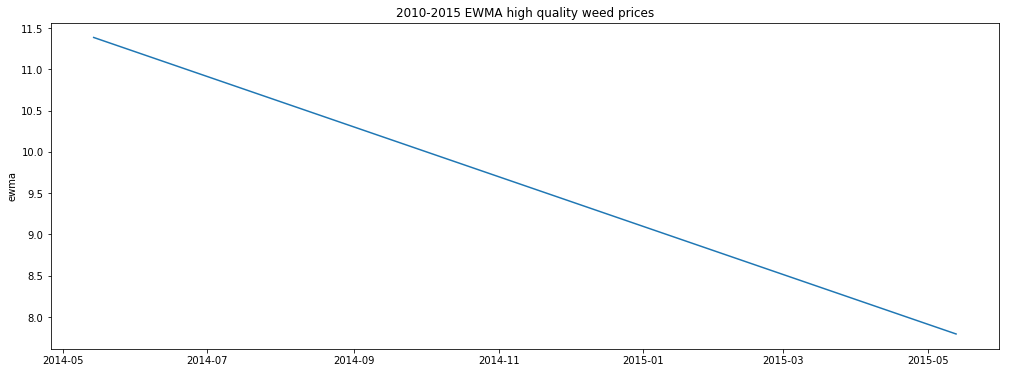

In [21]:
plt.figure(figsize=(17,6))
sns.lineplot(x=pred_df.index, y=pred_df['ewma']).set_title('2010-2015 EWMA high quality weed prices')